In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os

DATA_PATH = "/content/drive/MyDrive/risklens/data/processed"

df = pd.read_csv(os.path.join(DATA_PATH, "application_features_day2.csv"))

df.shape


(307511, 12)

In [ ]:
TARGET = "TARGET"

X = df.drop(columns=[TARGET, "SK_ID_CURR"])
y = df[TARGET]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


In [ ]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)

# align columns
X_train, X_val = X_train.align(X_val, join="left", axis=1, fill_value=0)


In [ ]:
X_train.isna().sum().sort_values(ascending=False).head(10)


,0
employment_ratio,41396
annuity_to_income,9
AMT_ANNUITY,9
CNT_FAM_MEMBERS,1
income_per_person,1
age_years,0
AMT_CREDIT,0
AMT_INCOME_TOTAL,0
loan_to_income,0
"loan_to_income_bucket_(1.818, 2.764]",0


In [ ]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median")

X_train_imputed = pd.DataFrame(
    num_imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_imputed = pd.DataFrame(
    num_imputer.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)


In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

lr.fit(X_train_imputed, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [ ]:
y_val_pred_proba = lr.predict_proba(X_val_imputed)[:, 1]


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_val, y_val_pred_proba)
roc_auc


np.float64(0.5854175382467075)

In [ ]:
from scipy.stats import ks_2samp

ks = ks_2samp(
    y_val_pred_proba[y_val == 0],
    y_val_pred_proba[y_val == 1]
).statistic

ks


np.float64(0.13076945554525915)

In [ ]:
from sklearn.metrics import average_precision_score

pr_auc = average_precision_score(y_val, y_val_pred_proba)
pr_auc


np.float64(0.10285495086858838)

In [ ]:
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": lr.coef_[0]
}).sort_values(by="coef", ascending=False)

coef_df


,feature,coef
3,CNT_FAM_MEMBERS,2.019649e-01
5,loan_to_income,8.721096e-02
10,"loan_to_income_bucket_(2.764, 3.906]",7.084415e-02
11,"loan_to_income_bucket_(3.906, 5.769]",4.933762e-02
9,"loan_to_income_bucket_(1.818, 2.764]",4.770955e-02
6,annuity_to_income,1.026332e-02
2,AMT_ANNUITY,7.787257e-06
7,income_per_person,3.793738e-06
1,AMT_CREDIT,-8.540056e-07
0,AMT_INCOME_TOTAL,-1.243771e-06


Application data alone provides limited discriminatory power.
Meaningful uplift in PD models requires historical repayment behavior from bureau and previous loans

# Retrain Logestic Reg
By Adding bureau credit history

In [ ]:
import pandas as pd
import numpy as np
import os

DATA_PATH = "/content/drive/MyDrive/risklens/data/processed"

df = pd.read_csv(
    os.path.join(DATA_PATH, "application_bureau_features_day4.csv")
)

df.shape


(307511, 19)

In [ ]:
TARGET = "TARGET"

X = df.drop(columns=[TARGET, "SK_ID_CURR"])
y = df[TARGET]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


In [ ]:
X_train.dtypes[X_train.dtypes == "object"]


,0
loan_to_income_bucket,object


In [ ]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)

X_train, X_val = X_train.align(X_val, join="left", axis=1, fill_value=0)


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_imp = pd.DataFrame(
    imputer.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)


In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

lr.fit(X_train_imp, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [ ]:
y_val_pred_proba = lr.predict_proba(X_val_imp)[:, 1]


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_val, y_val_pred_proba)
roc_auc

np.float64(0.624470775048736)

In [ ]:
from scipy.stats import ks_2samp

ks = ks_2samp(
    y_val_pred_proba[y_val == 0],
    y_val_pred_proba[y_val == 1]
).statistic

ks


np.float64(0.1867799660527022)

In [ ]:
from sklearn.metrics import average_precision_score

pr_auc = average_precision_score(y_val, y_val_pred_proba)
pr_auc


np.float64(0.1230160826677415)

In [ ]:
coef_df = pd.DataFrame({
    "feature": X_train_imp.columns,
    "coef": lr.coef_[0]
}).sort_values(by="coef", ascending=False)

coef_df.head(10), coef_df.tail(10)


(                                 feature      coef
 10                      num_active_loans  0.162721
 5                         loan_to_income  0.097551
 3                        CNT_FAM_MEMBERS  0.057339
 9                       num_bureau_loans  0.049783
 17  loan_to_income_bucket_(2.764, 3.906]  0.011129
 14                       max_delinquency  0.008704
 18  loan_to_income_bucket_(3.906, 5.769]  0.007861
 16  loan_to_income_bucket_(1.818, 2.764]  0.007722
 15              total_delinquency_months  0.007329
 6                      annuity_to_income  0.004921,
                                   feature          coef
 19  loan_to_income_bucket_(5.769, 84.737]  1.413747e-03
 2                             AMT_ANNUITY  1.338553e-05
 7                       income_per_person  1.713384e-06
 13                      total_credit_debt  5.246889e-08
 0                        AMT_INCOME_TOTAL -5.581538e-08
 12                  total_credit_exposure -7.186896e-08
 1                          

# Results


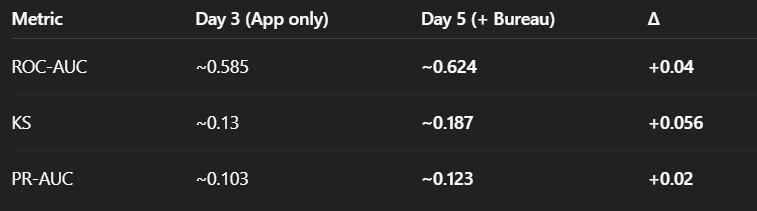

# Day 6 — Risk Scorecard & Expected Loss


In [55]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


In [56]:
DATA_PATH = "/content/drive/MyDrive/risklens/data/processed"

df = pd.read_csv(
    os.path.join(DATA_PATH, "application_bureau_features_day4.csv")
)

TARGET = "TARGET"
X = df.drop(columns=[TARGET, "SK_ID_CURR"])
y = df[TARGET]


In [57]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


In [58]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_train, X_val = X_train.align(X_val, join="left", axis=1, fill_value=0)


In [59]:
imputer = SimpleImputer(strategy="median")

X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_imp = pd.DataFrame(
    imputer.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)


In [60]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

lr.fit(X_train_imp, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [61]:
pd_val = lr.predict_proba(X_val_imp)[:, 1]


In [62]:
score_df = df.loc[X_val_imp.index, ["SK_ID_CURR", "AMT_CREDIT"]].copy()
score_df["PD"] = pd_val


**Convert PD → Risk Score**

In [ ]:
A = 600
B = 50

score_df["odds"] = score_df["PD"] / (1 - score_df["PD"])
score_df["risk_score"] = A - B * np.log(score_df["odds"])


In [ ]:
score_df["risk_score"].describe()


,risk_score
count,76878.000000
mean,605.299701
std,23.102252
min,56.770025
25%,591.624375
50%,605.672885
75%,619.370093
max,2018.535973


**Create Risk Bands**

In [ ]:
score_df["risk_band"] = pd.qcut(
    score_df["risk_score"],
    q=4,
    labels=["D (High Risk)", "C (Medium)", "B (Low)", "A (Very Low)"]
)


In [ ]:
score_df["risk_band"].value_counts(normalize=True)


,proportion
risk_band,
D (High Risk),0.250007
A (Very Low),0.250007
C (Medium),0.249993
B (Low),0.249993


**Expected Loss**

In [ ]:
LGD = 0.45

score_df["EAD"] = score_df["AMT_CREDIT"]
score_df["expected_loss"] = score_df["PD"] * LGD * score_df["EAD"]


In [ ]:
score_df["expected_loss"].sum()


np.float64(9560328662.917906)

In [ ]:
score_df.groupby("risk_band")[
    ["PD", "expected_loss"]
].mean()


/tmp/ipython-input-670859468.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_df.groupby("risk_band")[


,PD,expected_loss
risk_band,,
D (High Risk),0.607834,150110.468329
C (Medium),0.505575,123049.209303
B (Low),0.438289,115089.095706
A (Very Low),0.347149,109179.260025


In [ ]:
OUTPUT_PATH = "/content/drive/MyDrive/risklens/data/outputs"
os.makedirs(OUTPUT_PATH, exist_ok=True)

score_df.to_csv(
    os.path.join(OUTPUT_PATH, "risk_scores_expected_loss_day6.csv"),
    index=False
)


We translated a PD model into a risk scorecard and quantified portfolio expected loss, enabling approval and pricing decisions.

PD monotonically decreases from D → A

Expected Loss monotonically decreases from D → A

# EXPLAINABILITY (SHAP) + MODEL DECISION

In [48]:
!pip install shap


In [49]:
import shap


In [50]:
explainer = shap.LinearExplainer(
    lr,
    X_train_imp,
    feature_perturbation="interventional"
)


/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [51]:
shap_values = explainer.shap_values(X_val_imp)


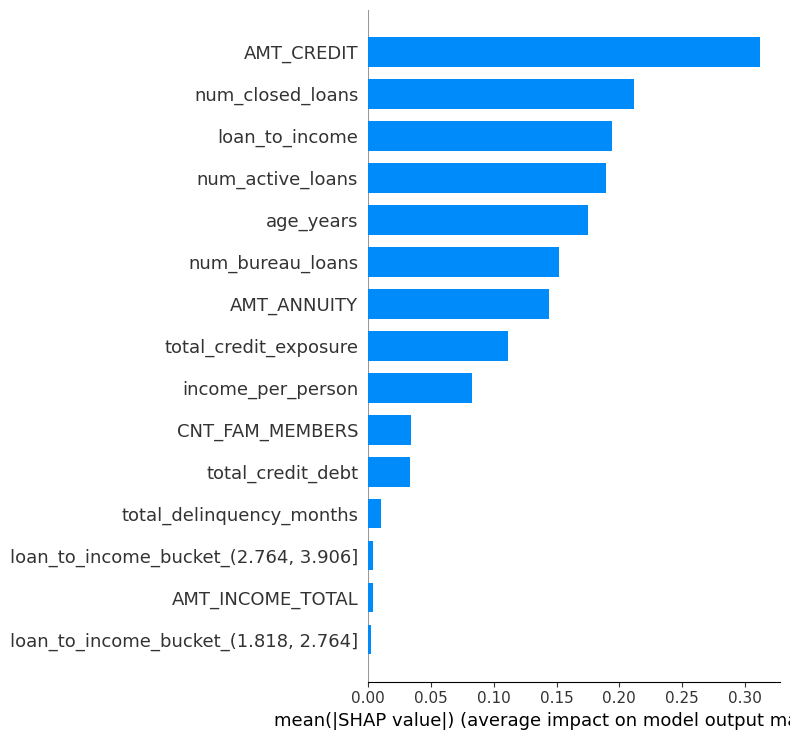

In [52]:
shap.summary_plot(
    shap_values,
    X_val_imp,
    plot_type="bar",
    max_display=15
)


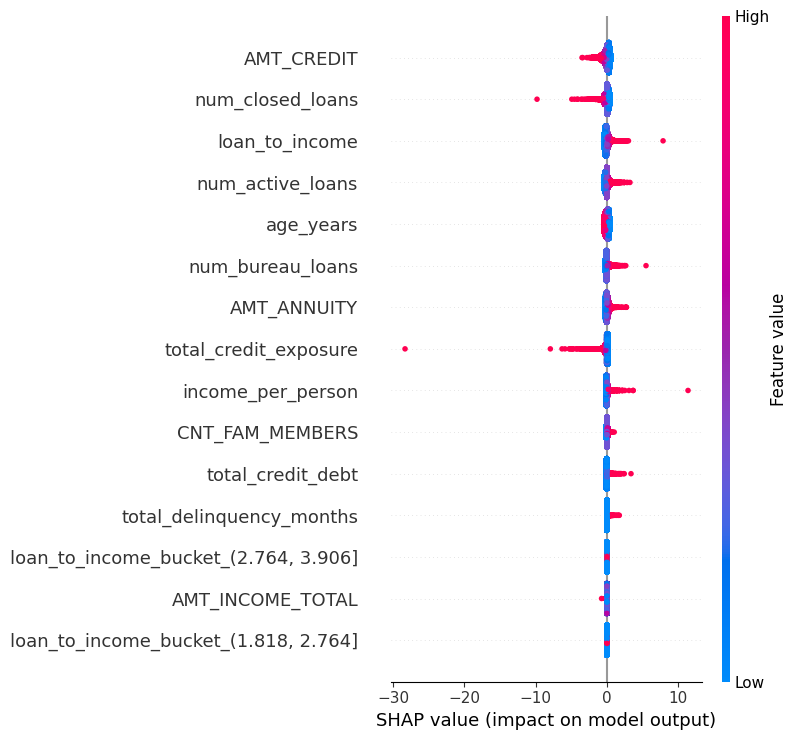

In [53]:
shap.summary_plot(
    shap_values,
    X_val_imp,
    max_display=15
)


LOCAL EXPLAINABILITY (WHY THIS CUSTOMER?)


In [54]:
score_df_sorted = score_df.sort_values("PD", ascending=False)

high_risk_idx = score_df_sorted.index[0]
low_risk_idx = score_df_sorted.index[-1]


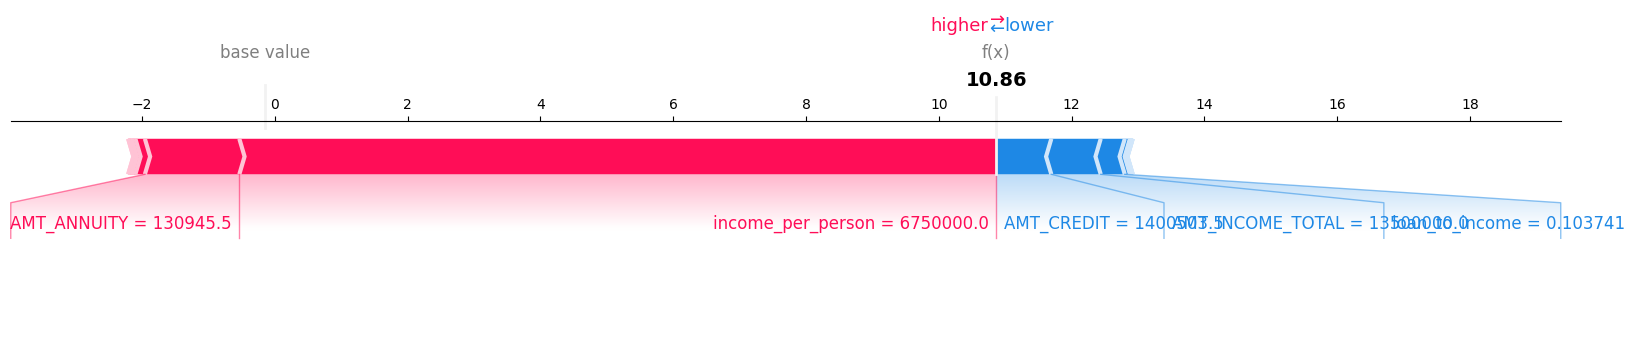

In [63]:
shap.force_plot(
    explainer.expected_value,
    shap_values[X_val_imp.index.get_loc(high_risk_idx)],
    X_val_imp.loc[high_risk_idx],
    matplotlib=True
)


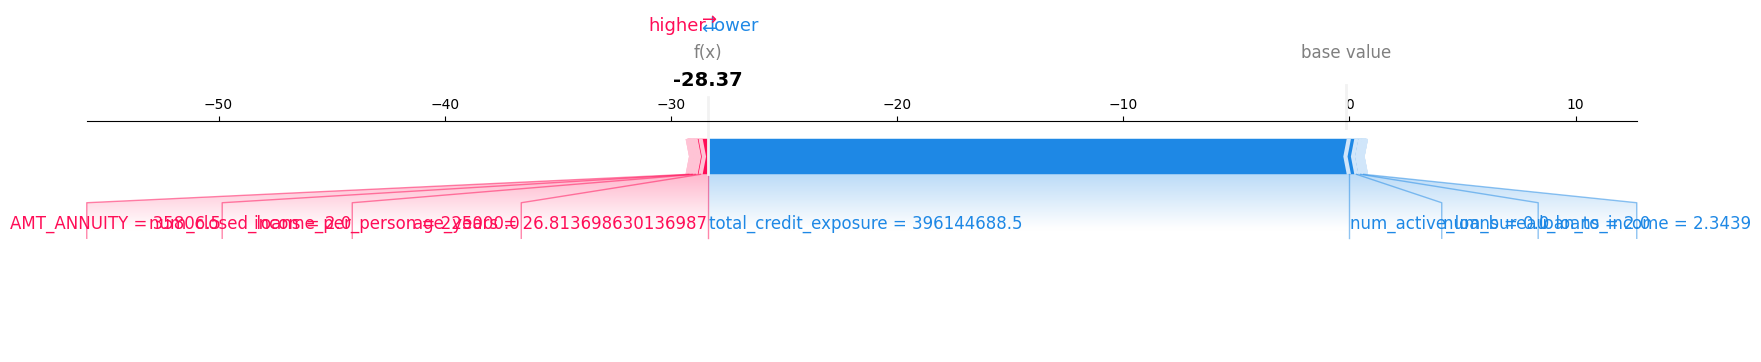

In [64]:
shap.force_plot(
    explainer.expected_value,
    shap_values[X_val_imp.index.get_loc(low_risk_idx)],
    X_val_imp.loc[low_risk_idx],
    matplotlib=True
)


# Using LightGBM

In [65]:
!pip install lightgbm


In [66]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import ks_2samp



In [67]:
X = df.drop(columns=["TARGET", "SK_ID_CURR"])
y = df["TARGET"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


In [68]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_train, X_val = X_train.align(X_val, join="left", axis=1, fill_value=0)


In [70]:
def clean_feature_names(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.replace("[", "_", regex=False)
        .str.replace("]", "_", regex=False)
        .str.replace("(", "_", regex=False)
        .str.replace(")", "_", regex=False)
        .str.replace(",", "_", regex=False)
        .str.replace(" ", "_", regex=False)
    )
    return df


In [71]:
X_train_lgb = clean_feature_names(X_train)
X_val_lgb = clean_feature_names(X_val)


In [72]:
lgb_model.fit(X_train_lgb, y_train)


[LightGBM] [Info] Number of positive: 18619, number of negative: 212014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.05, n_estimators=300, n_jobs=-1, random_state=42,
               subsample=0.8)

In [73]:
lgb_pd = lgb_model.predict_proba(X_val_lgb)[:, 1]


In [74]:
lgb_auc = roc_auc_score(y_val, lgb_pd)
lgb_auc


np.float64(0.6750572000622213)

In [75]:
lgb_ks = ks_2samp(
    lgb_pd[y_val == 0],
    lgb_pd[y_val == 1]
).statistic
lgb_ks


np.float64(0.26105185076176035)

In [76]:
lgb_pr = average_precision_score(y_val, lgb_pd)
lgb_pr


np.float64(0.16272185400865874)

In [77]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "LightGBM"],
    "ROC_AUC": [roc_auc, lgb_auc],
    "KS": [ks, lgb_ks],
    "PR_AUC": [pr_auc, lgb_pr]
})

comparison


,Model,ROC_AUC,KS,PR_AUC
0,Logistic Regression,0.624471,0.186780,0.123016
1,LightGBM,0.675057,0.261052,0.162722


In [78]:
lgb_score_df = df.loc[X_val.index, ["SK_ID_CURR", "AMT_CREDIT"]].copy()
lgb_score_df["PD"] = lgb_pd
lgb_score_df["expected_loss"] = lgb_score_df["PD"] * 0.45 * lgb_score_df["AMT_CREDIT"]

lgb_score_df["expected_loss"].sum()


np.float64(8837465635.948824)

In [79]:
import joblib
import os

MODEL_PATH = "/content/drive/MyDrive/risklens/backend/models"
os.makedirs(MODEL_PATH, exist_ok=True)

# Save logistic model
joblib.dump(lr, f"{MODEL_PATH}/logistic_pd_model.pkl")

# Save imputer
joblib.dump(imputer, f"{MODEL_PATH}/imputer.pkl")

# Save feature columns (VERY IMPORTANT)
joblib.dump(
    X_train_imp.columns.tolist(),
    f"{MODEL_PATH}/feature_columns.pkl"
)


['/content/drive/MyDrive/risklens/backend/models/feature_columns.pkl']

In [80]:
joblib.dump(lgb_model, f"{MODEL_PATH}/lightgbm_pd_model.pkl")


['/content/drive/MyDrive/risklens/backend/models/lightgbm_pd_model.pkl']